# Model 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load data for train

In [3]:
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')
#buffer datetime
buffer_datetime_train = train.datetime
#remove object
train = train.select_dtypes(exclude=['object'])
#replace misssing value
train.fillna(0,inplace=True)

# Load data for test

test = pd.read_csv('data/test_data/dataset_rev4_test.csv')
#buffer datetime
buffer_datetime_test = test.datetime
#remove object
test = test.select_dtypes(exclude=['object'])
#replace misssing value
test.fillna(0,inplace=True)

print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

print("features:",list(train.columns))

# Remove outlier

In [4]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# Normalize

import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('P')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('P',axis = 1))
mat_y = np.array(train.P).reshape((118427,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

# Create training_set and prediction_set

# List of features
COLUMNS = col_train #column train (x train)
FEATURES = col_train_bis  #column train-label (x test)
LABEL = "P"

# Columns
feature_cols = FEATURES #(x test)

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS] #column train (x train)
prediction_set = train.P # column P

print(type(training_set))
print(type(prediction_set))

# Create x_train and Test

x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Create training_set

y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_sub = training_set[col_train]

# Create testing_set

y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

In [5]:
P = train["P"]
P = P.values
P = P.astype('float32')
P

array([0.  , 0.  , 0.  , ..., 0.18, 0.12, 0.12], dtype=float32)

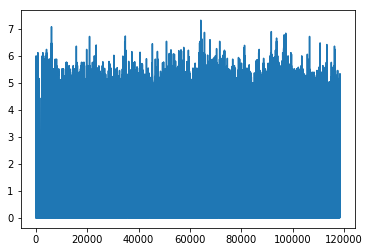

In [6]:
plt.plot(P)
plt.show()

In [7]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
# fix random seed for reproducibility
np.random.seed(7)

In [9]:
# normalise the dataset
scaler = MinMaxScaler(feature_range=(0,1))
P = P.reshape(-1, 1)
P = scaler.fit_transform(P)
P[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [10]:
# Split data into train and test set# Split 
train_size = int(len(P) * 0.67)
test_size = len(P) - train_size
train, test = P[0:train_size,:], P[train_size:len(P),:]

In [11]:
len(train), len(test)

(79346, 39081)

In [12]:
def create_dataset(dataset, look_back=1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
print(create_dataset(P)[1])

[0.         0.         0.         ... 0.02459016 0.02459016 0.01639344]


In [14]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [15]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
trainX

array([[[0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ]],

       ...,

       [[0.79918027, 0.68852454, 0.5778688 ]],

       [[0.68852454, 0.5778688 , 0.7336065 ]],

       [[0.5778688 , 0.7336065 , 0.557377  ]]], dtype=float32)

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=4, verbose=2)

Epoch 1/500
 - 68s - loss: 0.0075
Epoch 2/500
 - 58s - loss: 0.0061
Epoch 3/500
 - 61s - loss: 0.0061
Epoch 4/500
 - 77s - loss: 0.0061
Epoch 5/500
 - 96s - loss: 0.0061
Epoch 6/500
 - 104s - loss: 0.0061
Epoch 7/500
 - 90s - loss: 0.0061
Epoch 8/500
 - 94s - loss: 0.0061
Epoch 9/500
 - 94s - loss: 0.0061
Epoch 10/500
 - 92s - loss: 0.0061
Epoch 11/500
 - 91s - loss: 0.0060
Epoch 12/500
 - 90s - loss: 0.0060
Epoch 13/500
 - 94s - loss: 0.0060
Epoch 14/500
 - 92s - loss: 0.0060
Epoch 15/500
 - 90s - loss: 0.0060
Epoch 16/500
 - 90s - loss: 0.0060
Epoch 17/500
 - 95s - loss: 0.0060
Epoch 18/500
 - 92s - loss: 0.0060
Epoch 19/500
 - 90s - loss: 0.0060
Epoch 20/500
 - 90s - loss: 0.0060
Epoch 21/500
 - 95s - loss: 0.0060
Epoch 22/500
 - 90s - loss: 0.0060
Epoch 23/500
 - 91s - loss: 0.0060
Epoch 24/500
 - 89s - loss: 0.0060
Epoch 25/500
 - 95s - loss: 0.0060
Epoch 26/500
 - 91s - loss: 0.0060
Epoch 27/500
 - 90s - loss: 0.0060
Epoch 28/500
 - 90s - loss: 0.0060
Epoch 29/500
 - 95s - loss: 

Epoch 232/500
 - 97s - loss: 0.0058
Epoch 233/500
 - 98s - loss: 0.0058
Epoch 234/500
 - 96s - loss: 0.0058
Epoch 235/500
 - 98s - loss: 0.0058
Epoch 236/500
 - 97s - loss: 0.0058
Epoch 237/500
 - 97s - loss: 0.0058
Epoch 238/500
 - 95s - loss: 0.0058
Epoch 239/500
 - 98s - loss: 0.0058
Epoch 240/500
 - 97s - loss: 0.0058
Epoch 241/500
 - 97s - loss: 0.0058
Epoch 242/500
 - 96s - loss: 0.0058
Epoch 243/500
 - 98s - loss: 0.0058
Epoch 244/500
 - 98s - loss: 0.0058
Epoch 245/500
 - 100s - loss: 0.0058
Epoch 246/500
 - 97s - loss: 0.0058
Epoch 247/500
 - 97s - loss: 0.0058
Epoch 248/500
 - 97s - loss: 0.0058
Epoch 249/500
 - 98s - loss: 0.0058
Epoch 250/500
 - 96s - loss: 0.0058
Epoch 251/500
 - 97s - loss: 0.0058
Epoch 252/500
 - 98s - loss: 0.0058
Epoch 253/500
 - 97s - loss: 0.0058
Epoch 254/500
 - 97s - loss: 0.0058
Epoch 255/500
 - 84s - loss: 0.0058
Epoch 256/500
 - 88s - loss: 0.0058
Epoch 257/500
 - 93s - loss: 0.0058
Epoch 258/500
 - 89s - loss: 0.0058
Epoch 259/500
 - 89s - loss

 - 38s - loss: 0.0058
Epoch 460/500
 - 38s - loss: 0.0058
Epoch 461/500
 - 38s - loss: 0.0058
Epoch 462/500
 - 38s - loss: 0.0058
Epoch 463/500
 - 38s - loss: 0.0058
Epoch 464/500
 - 38s - loss: 0.0058
Epoch 465/500
 - 38s - loss: 0.0058
Epoch 466/500
 - 38s - loss: 0.0058
Epoch 467/500
 - 38s - loss: 0.0058
Epoch 468/500
 - 38s - loss: 0.0058
Epoch 469/500
 - 38s - loss: 0.0058
Epoch 470/500
 - 38s - loss: 0.0058
Epoch 471/500
 - 38s - loss: 0.0058
Epoch 472/500
 - 38s - loss: 0.0058
Epoch 473/500
 - 38s - loss: 0.0058
Epoch 474/500
 - 38s - loss: 0.0058
Epoch 475/500
 - 38s - loss: 0.0058
Epoch 476/500
 - 38s - loss: 0.0058
Epoch 477/500
 - 38s - loss: 0.0058
Epoch 478/500
 - 38s - loss: 0.0058
Epoch 479/500
 - 39s - loss: 0.0058
Epoch 480/500
 - 38s - loss: 0.0058
Epoch 481/500
 - 38s - loss: 0.0058
Epoch 482/500
 - 38s - loss: 0.0058
Epoch 483/500
 - 38s - loss: 0.0058
Epoch 484/500
 - 38s - loss: 0.0058
Epoch 485/500
 - 38s - loss: 0.0058
Epoch 486/500
 - 38s - loss: 0.0058
Epoch 